In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from os import path
from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams
from linear_opt.lin_metabolism import SingleSubstrateMMRateLaw
from linear_opt.lin_metabolism import MultiSubstrateMMRateLaw
from linear_opt.lin_metabolism import ZerothOrderRateLaw
from matplotlib.ticker import LogFormatter 

from SALib import ProblemSpec

# Approximate concentrations and ratios for plotting
# Based on Bennett et al. 2009 measurements in E. coli
DEFAULT_ATP = 1.4e-6
DEFAULT_NADH = 1.2e-7
DEFAULT_RE = 10
DEFAULT_RA = 0.3

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
#lam.print_model()

In [3]:
# Concentrations are typically ~1 mM, converting to mol/gCDW
# If the density rho ≈ 1000 g/L, 1/rho ≈ 1e-3 L/g = 1 mL/g so... 
# 1e-3 mol/L x 1e-3 L/g x 0.3 gDW/g x 2 gDW/gCDW = 1.5e-7 mol/gCDW
params = GrowthRateOptParams(min_phi_O=0.4, 
                             #rate_law=ZerothOrderRateLaw(),
                             do_dilution=True,
                             rate_law=SingleSubstrateMMRateLaw(),
                             fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                             fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RE)
p = lam.max_growth_rate_problem(params)
p.solve(verbose=True)

#lam.solution_as_dict(p)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 25 03:53:30 PM: Your problem has 5 variables, 3 constraints, and 23 parameters.
(CVXPY) Aug 25 03:53:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 25 03:53:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 25 03:53:30 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 25 03:53:30 PM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Aug 25 03:53:30 PM: Applying reduction EvalParams
(CVXPY) Aug 25 03:53:30 PM: Applying 

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


1.343980153629763

In [4]:
# Do a quick run of the model to make sure it is feasible
params = GrowthRateOptParams(maintenance_cost=1e-6, phi_O=0.4)
opt, problem = lam.maximize_growth_rate(params)
opt

2.2870588142242774

In [5]:
concs = np.logspace(-7, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        opt, _ = lam.maximize_growth_rate(params)
        lambda_grid[i, j] = opt

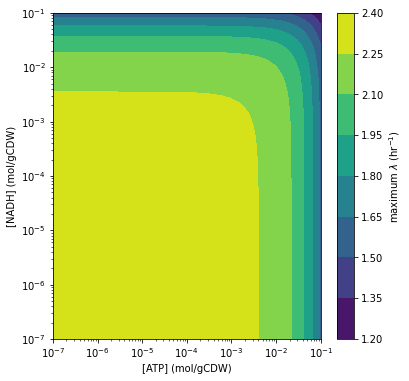

In [6]:
plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis')
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)')
plt.show()

In [7]:
# Same as above, multi-substrate michaelis menten rate law
concs = np.logspace(-8, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        rl = MultiSubstrateMMRateLaw()
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=10, fixed_ra=0.3,
                                     rate_law=rl)
        opt = np.NaN
        try:
            opt, _ = lam.maximize_growth_rate(params)
        except:
            # Optimal solution not found
            pass
        
        lambda_grid[i, j] = opt

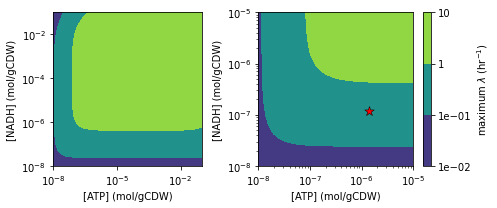

In [8]:
fig, axs = plt.subplots(figsize=(7, 3), ncols=2, width_ratios=[1, 1.3])

plt.sca(axs[0])
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')

plt.sca(axs[1])
# plot zoomed in on the range of ATP and NADH concentrations we care about
# which are 1e-8 to 1e-5 for both 
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
plt.xlim(1e-8, 1e-5)
plt.ylim(1e-8, 1e-5)
formatter = LogFormatter(10, labelOnlyBase=False)
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)', format=formatter)

# put a * at the Bennet concentrations of ATP ≈ 1.4e-6 (9.6 mM) and NADH ≈ 1.2e-7 (83 uM)
plt.scatter(DEFAULT_ATP, DEFAULT_NADH, marker='*', color='red', edgecolor='k', lw=0.5, s=100)

plt.tight_layout()
plt.show()

In [9]:
# Here is a model that has no homeostasis (phi_H <= 0),
# no maintenance (ATP_maint = 0), but can alter biomass
# composition through phi_O. We set a maximum lambda
# so that we can run the model over a range of lambda values.
params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, 
                             max_lambda_hr=0.1, max_phi_H=0,
                             fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                             fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
                                
p = lam.max_growth_rate_problem(params)
lambdas = np.arange(0.1, 1.501, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.solution_as_dict(p, params)
    d.update(lam.model_as_dict())
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df['max_lambda_hr'] = lambdas
phi_df.head()

,opt_status,lambda_hr,maint,max_lambda_hr,phi_O,min_phi_O,C_red_conc,C_ox_conc,E_red_conc,E_ox_conc,...,ATP_homeostasis_m_kDa,ZCB,ZCorg,ZCprod,S1,S2,S3,S4,S5,S6
0,optimal,0.10,0.0,0.10,0.973765,0.4,1.0,1.0,1.0,1.0,...,2000.0,0.0,0.0,4.0,2.0,-0.5,0.5,1.0,-0.3,0.0
1,optimal,0.11,0.0,0.11,0.971142,0.4,1.0,1.0,1.0,1.0,...,2000.0,0.0,0.0,4.0,2.0,-0.5,0.5,1.0,-0.3,0.0
2,optimal,0.12,0.0,0.12,0.968518,0.4,1.0,1.0,1.0,1.0,...,2000.0,0.0,0.0,4.0,2.0,-0.5,0.5,1.0,-0.3,0.0
3,optimal,0.13,0.0,0.13,0.965895,0.4,1.0,1.0,1.0,1.0,...,2000.0,0.0,0.0,4.0,2.0,-0.5,0.5,1.0,-0.3,0.0
4,optimal,0.14,0.0,0.14,0.963271,0.4,1.0,1.0,1.0,1.0,...,2000.0,0.0,0.0,4.0,2.0,-0.5,0.5,1.0,-0.3,0.0


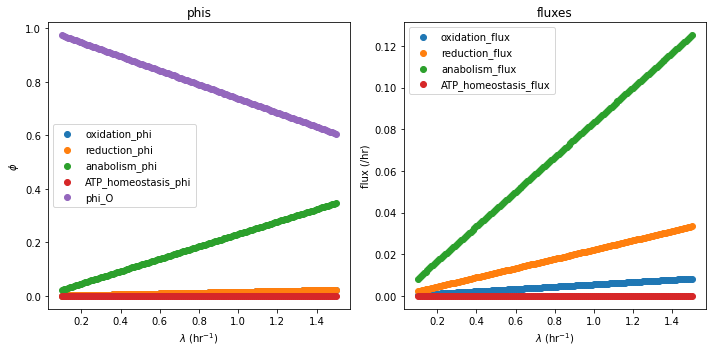

In [10]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])

x = phi_df['lambda_hr']
phi_cols = [c for c in phi_df.columns if c.endswith('phi')] + ['phi_O']
for col in phi_cols:
    plt.scatter(x, phi_df[col], label=col)
plt.title('phis')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   
plt.legend()

plt.sca(axs[1])
j_cols = [c for c in phi_df.columns if c.endswith('flux')]
for col in j_cols:
    plt.scatter(x, phi_df[col]*3600, label=col)
plt.title('fluxes')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

ref_lam = lmm.copy()
ref_lam.set_ZCorg(-1)
params = GrowthRateOptParams(phi_O=phi_O, do_dilution=True,
                                    fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                    fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
m, opt_p = ref_lam.maximize_growth_rate(params)
print(m, opt_p.status)

1.993867011848059 optimal


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [35]:
# Sweep a range of biomass ZC values
ZCBs = np.arange(-3, 3.01, 0.05)
phi_Os = np.arange(0.1,0.41,0.1)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for z in ZCBs:
    for phi_O in phi_Os:
        # Test with and without ATP homeostasis -- first with
        ref_lam = lmm.copy()
        ref_lam.set_ZCB(z)
        # Note we are fixing phi_O here to highlight the contribution of phi_H
        params = GrowthRateOptParams(phi_O=phi_O, do_dilution=True,
                                    fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                    fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params)
        d = ref_lam.model_as_dict()
        d.update(ref_lam.solution_as_dict(opt_p, params))
        d.update(params.as_dict())
        results.append(d)

        # Now without -- seting max_phi_H = 0
        params_nh = GrowthRateOptParams(phi_O=phi_O, do_dilution=True, max_phi_H=0,
                                        fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                        fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params_nh)
        d = ref_lam.solution_as_dict(opt_p, params_nh)
        d.update(ref_lam.model_as_dict())
        d.update(params_nh.as_dict())
        results.append(d)

zc_sensitivity_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [36]:
def S6_bounds(row):
    """Upper and lower bounds on S6.

    Args:
        row: dataframe row. 
    """
    g_ana = row.anabolism_gamma
    g_red = row.reduction_gamma
    g_ox = row.oxidation_gamma
    g_h = row.ATP_homeostasis_gamma
    phi_O = row.phi_O
    b = row.maint
    A = row.ATP_conc
    N = row.ECH_conc
    mC = MW_C_ATOM
    S1, S2, S3, S4, S5, S6 = row.S1, row.S2, row.S3, row.S4, row.S5, row.S6

    phi_term = (phi_O-1)
    b_term = (b + S5*g_ox*phi_term)

    # Handle lower bound first
    num =  S2*g_red*b_term + mC*g_ana*(b*N - (A*S2-N*S4)*phi_term*g_red)
    denom = g_ana*(b + S4*g_red*phi_term)
    lb = num / denom 

    # Now upper bound
    num = S1*g_ox*b_term + mC*g_ana*(b*N - (A*S1-N*S3)*phi_term*g_red)
    denom = g_ana*(b + S3*g_ox*phi_term)
    ub = num / denom

    return lb, ub

def analytic_lambda(row):
    """Calculates lambda from Js, expression derived from mass balances."""
    mC = MW_C_ATOM
    J_ox = row.oxidation_flux
    J_h = row.ATP_homeostasis_flux
    b = row.maint
    S1, S2, S3, S4, S5, S6 = row.S1, row.S2, row.S3, row.S4, row.S5, row.S6
    A = row.ATP_conc
    N = row.ECH_conc
    num = mC*(S2*(b + J_h - J_ox*S3)+J_ox*S1*S4)
    denom = mC*(A*S2-N*S4)-S2*S5+S4*S6
    return -3600*num/denom

def analytic_lambda_opt(row):
    """Calculates gamma from an analytic solution by Lagrange multipliers.

    This solution is derived for the case of zero-order kinetics with dilution.     
    """
    g_ana = row.anabolism_gamma
    g_red = row.reduction_gamma
    g_ox = row.oxidation_gamma
    g_h = row.ATP_homeostasis_gamma
    phi_h = row.ATP_homeostasis_phi
    phi_O = row.phi_O
    b = row.maint
    A = row.ATP_conc
    N = row.ECH_conc
    mC = MW_C_ATOM
    S1, S2, S3, S4, S5, S6 = row.S1, row.S2, row.S3, row.S4, row.S5, row.S6
    phi_term = (1 - phi_h - phi_O)
    S12_term = (S2*g_red-S1*g_ox)
    S34_term = (S4*g_red-S3*g_ox)
    num = S12_term*(S3*g_ox*phi_term - g_h*phi_h - b)
    num -= S1*g_ox*S34_term*phi_term
    denom = ((S5/mC) - A - (S3*g_ox)/(mC*g_ana))*S12_term
    denom -= ((S6/mC) - N - (S1*g_ox)/(mC*g_ana))*S34_term
    return -3600*num/denom

zc_sensitivity_df['analytic_lambda'] = zc_sensitivity_df.apply(analytic_lambda, axis=1)
zc_sensitivity_df['analytic_lambda_opt'] = zc_sensitivity_df.apply(analytic_lambda_opt, axis=1)

bounds = zc_sensitivity_df.apply(S6_bounds, axis=1)
bounds = pd.DataFrame(bounds.tolist(), index=zc_sensitivity_df.index, columns=['S6_lb', 'S6_ub'])
zc_sensitivity_df = pd.concat([zc_sensitivity_df, bounds], axis=1)
    

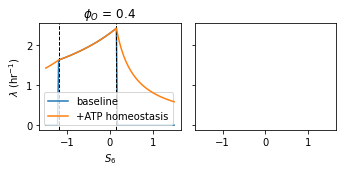

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 2.5), sharex=True, sharey=True)

ZCB = zc_sensitivity_df.ZCB.values[0]

plt.sca(axs[0])
plt.title(r'$\phi_O$ = {0:.1f}'.format(phi_O))
mask = zc_sensitivity_df['phi_O'] == 0.4
masked = zc_sensitivity_df[mask]

phi_H_included = masked[masked['opt.max_phi_H_set'] == False]
no_phi_H = masked[masked['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.S6, no_phi_H.lambda_hr, label=r'baseline')
plt.plot(phi_H_included.S6, phi_H_included.lambda_hr, label=r'+ATP homeostasis', 
         zorder=10)

plt.axvline(no_phi_H.S6_lb.values[0], color='k', ls='--', lw=1)
plt.axvline(no_phi_H.S6_ub.values[0], color='k', ls='--', lw=1)


plt.legend()
plt.xlabel('$S_6$')
plt.ylabel(r'$\lambda$ (hr$^{-1}$)')
    
plt.tight_layout()
plt.show()

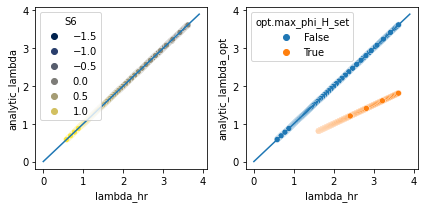

In [33]:

fig, axs = plt.subplots(ncols=2, figsize=(6,3))

mask = zc_sensitivity_df['opt_status'] == 'optimal'
masked = zc_sensitivity_df[mask]

plt.sca(axs[0])
sns.scatterplot(data=masked, x='lambda_hr', y='analytic_lambda', hue='S6', palette='cividis')
xs = np.arange(0, 4, 0.1)
plt.plot(xs, xs)

plt.sca(axs[1])
sns.scatterplot(data=masked, x='lambda_hr', y='analytic_lambda_opt', hue='opt.max_phi_H_set')    
plt.plot(xs, xs)

plt.tight_layout()

plt.show()

In [38]:
zc_sensitivity_df[zc_sensitivity_df['opt.max_phi_H_set']].ATP_homeostasis_phi.unique()

array([0.00000000e+00, 1.18842942e-10, 1.22356298e-10, 1.38639625e-10,
       1.60574629e-10, 3.53697173e-10, 4.06851518e-10, 4.74144064e-10,
       5.73022157e-10])

In [15]:
ZCBs = np.arange(-3, 3.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 5, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
results = []
for z in ZCBs:
    for phi_O in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    try:
                        ref_lam = lmm.copy()
                        ref_lam.set_ZCB(z)
                        ref_lam.set_process_mass('reduction', resp_cost)
                        ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                        ref_lam.set_ATP_yield('reduction', atp_per_e)

                        params = GrowthRateOptParams(
                            phi_O=phi_O, do_dilution=True,
                            fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                            fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
                        m, opt_p = ref_lam.maximize_growth_rate(params)

                        if opt_p.status != cp.OPTIMAL:
                            continue
                        
                        d = ref_lam.model_as_dict()
                        d.update(ref_lam.solution_as_dict(opt_p, params))
                        d['reduction_ATP_per_e'] = atp_per_e
                        d.update(params.as_dict())
                        results.append(d)
                    except Exception as e:
                        print(e)
                        continue
res_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)
/opt/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


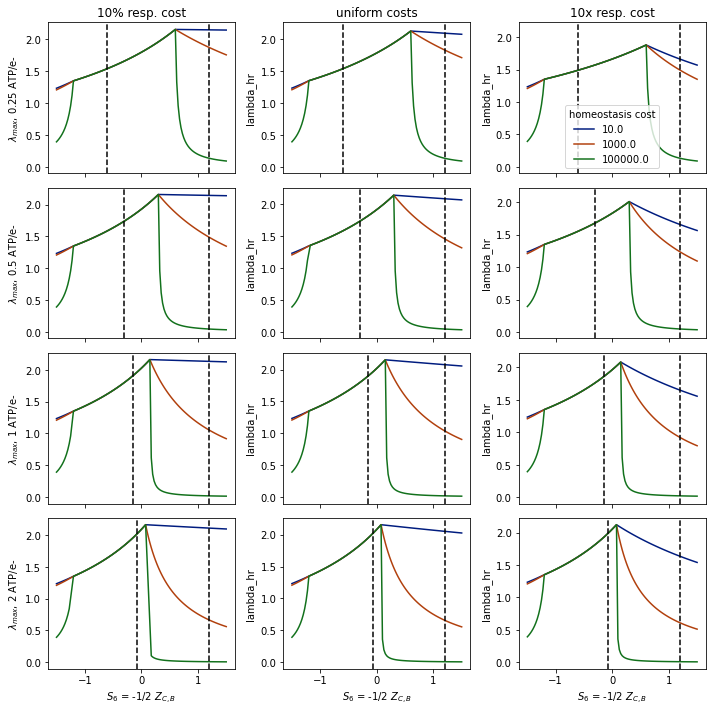

In [16]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

N = DEFAULT_NADH
A = DEFAULT_ATP
mC = MW_C_ATOM

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.phi_O == phi_os[2])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_hr', hue='ATP_homeostasis_m_kDa', palette='dark')
        
        masked = res_df[mask]
        S1 = masked.S1.values[0]
        S2 = masked.S2.values[0]
        S3 = masked.S3.values[0]
        S4 = masked.S4.values[0]
        S5 = masked.S5.values[0]

        # bounds at zero maintenance (b=0)
        S6_lb = (mC*(-A*S2 + N*S4)-S2*S5)/S4 
        S6_ub = (mC*(-A*S1 + N*S3)-S1*S5)/S3
        plt.axvline(S6_lb, color='k', linestyle='--')
        plt.axvline(S6_ub, color='k', linestyle='--')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

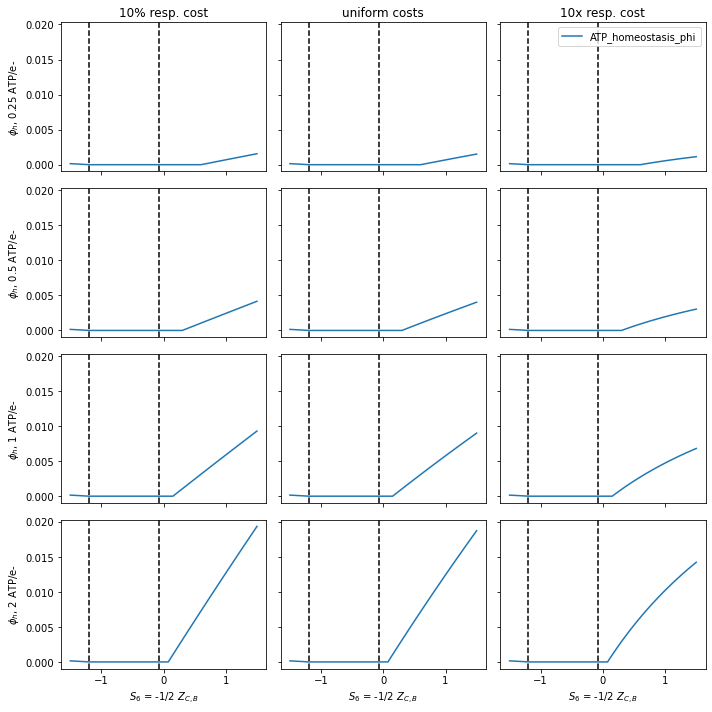

In [17]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey=True)
phi_cols = [c for c in res_df.columns if c.endswith('phi')] + ['phi_O']
phi_cols = ['ATP_homeostasis_phi']

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.phi_O == phi_os[1])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df.ATP_homeostasis_m_kDa == 10)

        S1 = masked.S1.values[0]
        S2 = masked.S2.values[0]
        S3 = masked.S3.values[0]
        S4 = masked.S4.values[0]
        S5 = masked.S5.values[0]

        # bounds at zero maintenance  
        S6_lb = -S2*S5/S4 
        S6_ub = S1*S5/S3
        plt.axvline(S6_lb, color='k', linestyle='--')
        plt.axvline(S6_ub, color='k', linestyle='--')

        for c in phi_cols:
            sns.lineplot(data=res_df[mask], x='S6', y=c, palette='dark', label=c)
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\phi_h$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend().set_visible(True)

plt.tight_layout()
#plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

In [18]:
def analytic_lambda(row):
    """Calculates lambda from Js, expression derived from mass balances."""
    mC = MW_C_ATOM
    J_ox = row.oxidation_flux
    J_h = row.ATP_homeostasis_flux
    b = row.maint
    S1, S2, S3, S4, S5, S6 = row.S1, row.S2, row.S3, row.S4, row.S5, row.S6
    A = row.ATP_conc
    N = row.ECH_conc
    num = mC*(S2*(b + J_h - J_ox*S3)+J_ox*S1*S4)
    denom = mC*(A*S2-N*S4)-S2*S5+S4*S6
    return -3600*num/denom

def analytic_lambda_opt(row):
    """Calculates gamma from an analytic solution by Lagrange multipliers.

    This solution is derived for the case of zero-order kinetics with dilution.     
    """
    g_ana = row.anabolism_gamma
    g_red = row.reduction_gamma
    g_ox = row.oxidation_gamma
    g_h = row.ATP_homeostasis_gamma
    phi_h = row.ATP_homeostasis_phi
    phi_O = row.phi_O
    b = row.maint
    A = row.ATP_conc
    N = row.ECH_conc
    mC = MW_C_ATOM
    S1, S2, S3, S4, S5, S6 = row.S1, row.S2, row.S3, row.S4, row.S5, row.S6
    phi_term = (1 - phi_h - phi_O)
    S12_term = (S2*g_red-S1*g_ox)
    S34_term = (S4*g_red-S3*g_ox)
    num = S12_term*(S3*g_ox*phi_term - g_h*phi_h - b)
    num -= S1*g_ox*S34_term*phi_term
    denom = ((S5/mC) - A - (S3*g_ox)/(mC*g_ana))*S12_term
    denom -= ((S6/mC) - N - (S1*g_ox)/(mC*g_ana))*S34_term
    return -3600*num/denom

# Just to check I know the units of Jana
res_df['lambda_Jana'] = res_df.apply(lambda x: x.anabolism_flux*MW_C_ATOM*3600, axis=1)
diff = res_df['lambda_Jana'] - res_df['lambda_hr']
print('Error < 1ppm?', (diff/res_df['lambda_hr'] < 1e-6).all())

res_df['analytic_lambda'] = res_df.apply(analytic_lambda, axis=1)
res_df['analytic_lambda_opt'] = res_df.apply(analytic_lambda_opt, axis=1)

Error < 1ppm? True


In [19]:
lam_lp = res_df['lambda_hr']
rel_diff = np.abs(res_df['analytic_lambda'] - lam_lp)/lam_lp 
mask = rel_diff > 0.05

cols = 'lambda_hr,analytic_lambda_opt,analytic_lambda,reduction_ATP_per_e,phi_O,maint'.split(',')
cols += [c for c in res_df.columns if c.startswith('S')]
cols += [c for c in res_df.columns if c.endswith('gamma')]
cols += [c for c in res_df.columns if c.endswith('phi')]

res_df[mask][cols]

,lambda_hr,analytic_lambda_opt,analytic_lambda,reduction_ATP_per_e,phi_O,maint,S1,S2,S3,S4,S5,S6,oxidation_gamma,reduction_gamma,anabolism_gamma,ATP_homeostasis_gamma,oxidation_phi,reduction_phi,anabolism_phi,ATP_homeostasis_phi
6764,3.887271,3.887261,-0.096779,2.00,0.1,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0800,0.0001,0.020000,3.119640e-09,0.000169,0.899831,2.659593e-09
6768,3.880713,3.880712,3.614943,2.00,0.1,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0080,0.0001,0.020000,2.360869e-06,0.001684,0.898313,5.946746e-09
6792,3.880724,3.880713,0.000000,2.00,0.1,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0080,0.0001,0.000002,0.000000e+00,0.001684,0.898316,0.000000e+00
6800,3.023433,3.023425,-0.065389,2.00,0.3,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0800,0.0001,0.020000,2.182190e-09,0.000131,0.699869,1.800134e-09
6828,3.018341,3.018332,0.000000,2.00,0.3,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0080,0.0001,0.000002,0.000000e+00,0.001310,0.698690,0.000000e+00
6836,2.159595,2.159589,-0.034962,2.00,0.5,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0800,0.0001,0.020000,1.268148e-09,0.000094,0.499906,9.667924e-10
6840,2.155952,2.155951,2.028876,2.00,0.5,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0080,0.0001,0.020000,1.313538e-06,0.000936,0.499063,2.849150e-09
6864,2.155958,2.155952,0.000000,2.00,0.5,0.0,2.0,-0.5,0.5,2.00,-0.3,0.075,0.0001,0.0080,0.0001,0.000002,0.000000e+00,0.000936,0.499064,0.000000e+00
7083,3.886542,3.886525,-0.183376,1.00,0.1,0.0,2.0,-0.5,0.5,1.00,-0.3,0.150,0.0001,0.0800,0.0001,0.020000,5.444285e-09,0.000337,0.899663,4.299384e-09
7111,3.873474,3.873457,0.000000,1.00,0.1,0.0,2.0,-0.5,0.5,1.00,-0.3,0.150,0.0001,0.0080,0.0001,0.000002,0.000000e+00,0.003362,0.896638,0.000000e+00


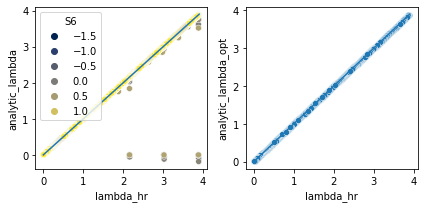

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(6,3))

plt.sca(axs[0])
sns.scatterplot(data=res_df, x='lambda_hr', y='analytic_lambda', hue='S6', palette='cividis')
xs = np.arange(0, 4, 0.1)
plt.plot(xs, xs)

plt.sca(axs[1])
sns.scatterplot(data=res_df, x='lambda_hr', y='analytic_lambda_opt',)    
plt.plot(xs, xs)

plt.tight_layout()

plt.show()

<AxesSubplot: xlabel='lambda_hr', ylabel='analytic_lambda'>

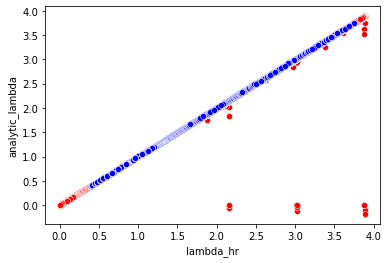

In [21]:
sns.scatterplot(data=res_df[res_df.S6 > 0], x='lambda_hr', y='analytic_lambda', color='red')
sns.scatterplot(data=res_df[res_df.S6 <= 0], x='lambda_hr', y='analytic_lambda', color='blue')


